# DNN TRAINING

M.Á. de Frutos (MAD-2020)

In [1]:
import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.1.0


Import dataset in NumPy's array format.

In [2]:
#PATH='data/Final/'
PATH='data/LEMT/Fusion/'

In [3]:
#Cragamos datos
stopDataset=np.load(PATH+'stop.npy')
noneDataset=np.load(PATH+'none.npy')
aheadDataset=np.load(PATH+ 'ahead.npy')
rightDataset=np.load(PATH+'right.npy')
leftDataset=np.load(PATH+'left.npy')

In [4]:
#Analisis rápido del tamañom NaN etc..
print('STOP:  shape\t', stopDataset[0].shape, '\tLong:',len(stopDataset), '\tNº NaN:', np.isnan(stopDataset).sum())
print('AHEAD: shape\t', aheadDataset[0].shape, '\tLong:',len(aheadDataset),'\tNº NaN:', np.isnan(aheadDataset).sum())
print('RIGHT: shape\t', rightDataset[0].shape, '\tLong:',len(rightDataset),'\tNº NaN:', np.isnan(rightDataset).sum())
print('LEFT:  shape\t', leftDataset[0].shape, '\tLong:',len(leftDataset), '\tNº NaN:', np.isnan(leftDataset).sum())
print('NONE:  shape\t', noneDataset[0].shape, '\tLong:',len(noneDataset), '\tNº NaN:', np.isnan(noneDataset).sum())

STOP:  shape	 (18, 2) 	Long: 1548 	Nº NaN: 0
AHEAD: shape	 (18, 2) 	Long: 1507 	Nº NaN: 0
RIGHT: shape	 (18, 2) 	Long: 1419 	Nº NaN: 0
LEFT:  shape	 (18, 2) 	Long: 1381 	Nº NaN: 0
NONE:  shape	 (18, 2) 	Long: 1372 	Nº NaN: 0


In [5]:
stopDataset.dtype

dtype('float64')

## Pre-Procesamiento previo
 - 1) Añadimos etiquetas
 - 2) Generamos único Datset
 - 3) Mezclamos aleatoriamente
 - 4) Divido conjunto Train/Test
 - 5) Serializo
 

Necesitamos añadir una etiqueta a cada tipo de datos antes de juntarlos todos.

Usaremos el siguiente código:

`0` -> `STOP`

`1` -> `AHEAD`

`2` -> `RIGHT`

`3` -> `LEFT`

`4` -> `NONE`


In [6]:
#Añadimos array de ETIQUETAS
labels = np.zeros(len(stopDataset))                         #Añadimos tantos 0 como datos de STOP
labels = np.append(labels, np.full((len(aheadDataset)), 1)) #Añadimos tantos 4 como datos de AHEAD
labels = np.append(labels, np.full((len(rightDataset)), 2)) #Añadimos tantos 1 como datos de RIGHT
labels = np.append(labels, np.full((len(leftDataset)), 3))  #Añadimos tantos 2 como datos de LEFT
labels = np.append(labels, np.full((len(noneDataset)), 4))  #Añadimos tantos 3 como datos de NONE


print(labels) #Mostramos todas las etiquetas
print("%i total examples for training." % len(labels)) #Y su suma total

[0. 0. 0. ... 4. 4. 4.]
7227 total examples for training.


In [7]:
#Juntamos todos los datos en un único dataset
dataset = np.append(stopDataset, aheadDataset, axis=0)
dataset = np.append(dataset, rightDataset, axis=0)
dataset = np.append(dataset, leftDataset, axis=0)
dataset = np.append(dataset, noneDataset, axis=0)

print("Tamaño Dataset:", len(dataset))

Tamaño Dataset: 7227


In [8]:
#Mezclados los datos manteniendo una correspondencia entre etiqueta y feature
from sklearn.utils import shuffle

X, y = shuffle(dataset, labels)
print(y) 

[1. 4. 0. ... 0. 0. 2.]


In [9]:
#Comvertimos etiquetas a tipo Categórico 
N_Clases= 5 #Nº de clases 
y = tf.keras.utils.to_categorical(y, N_Clases)
print("e.g.: ",y[0])

e.g.:  [0. 1. 0. 0. 0.]


In [10]:
#Separo un 20% de datos para Test
from sklearn.model_selection import train_test_split #Divido los datos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=50) 

In [11]:
#Ajustamos tamaño del array para Red neuronal
print("Entrada:")
print(" Train:", X_train.shape, len (y_train))
print(" Test:", X_test.shape, len (y_test))

#Convertimos 18 keypoints *2 coordenadas X,y -> 36
X_train = X_train.reshape(len(X_train), 36) 
X_test = X_test.reshape(len(X_test), 36) 

print("\nSalida:")
print(" Train:", X_train.shape, len (y_train))
print(" Test:", X_test.shape, len (y_test))


Entrada:
 Train: (5781, 18, 2) 5781
 Test: (1446, 18, 2) 1446

Salida:
 Train: (5781, 36) 5781
 Test: (1446, 36) 1446


### Func. Gráficas:

In [12]:
#Gráficas

def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2,history3, name1="Red 1",
                        name2="Red 2", name3="Red 3", title="Graph title"):
    
    """Compara losses de dos entrenamientos con nombres"""
    
    plt.plot(history1.history['val_loss'], color="red")
    #plt.plot(history1.history['val_loss'], 'r--', color="red")
    plt.plot(history2.history['val_loss'], color="blue")
    #plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.plot(history3.history['val_loss'], color="green")
    #plt.plot(history3.history['val_loss'], 'r--', color="green")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend([name1, 
                name2,
                name3],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2,history3, name1="Red 1",
                        name2="Red 2", name3="Red 3", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres"""
    plt.plot(history1.history['val_acc'], color="red")
    #plt.plot(history1.history['val_acc'], 'r--', color="red")
    plt.plot(history2.history['val_acc'], color="blue")
    #plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.plot(history3.history['val_acc'], color="green")
    #plt.plot(history3.history['val_acc'], 'r--', color="green")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend([name1, 
                name2, 
                name3],
               loc='lower right')
    plt.show()
    
# Pinta MATRIZ de CONFUSIÓN- Código extraideo de la web de SKLEARN
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='MLP - CONFUSION MATRIX',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

## Red Neuronal:

In [13]:
## MODELO_1
model_1= tf.keras.models.Sequential([
    #DNN 1                                 
    tf.keras.layers.Dense(128, activation='relu',input_shape=(36,)),
    tf.keras.layers.Dropout(0.5),
    #DNN 2
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #DNN 3
    tf.keras.layers.Dense(y.shape[1], activation='softmax', name ="LastLayer")
])

#Summary
model_1.summary()

#Compile
model_1.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
#Entreno
batch_size = 32
epochs=300

history1=model_1.fit(X_train, y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_split=0.2,
                   verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4736      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
LastLayer (Dense)            (None, 5)                 645       
Total params: 21,893
Trainable params: 21,893
Non-trainable params: 0
_________________________________________________________________


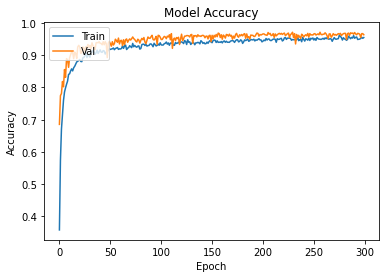

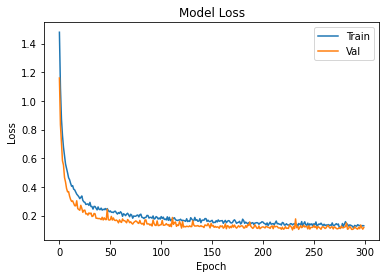

Train loss: 0.074835904
Train accuracy: 0.9704526
1446/1446 [==============================] - 0s 31us/sample - loss: 0.1473 - acc: 0.9578
Test loss: 0.14727755655556463
Test accuracy: 0.95781463


In [14]:

#Grafico
plot_acc(history1)
plot_loss(history1)


#Resultados conjunto Entrenamiento
train_loss, train_acc =model_1.test_on_batch(X_train, y_train)
print('Train loss:', train_loss)
print('Train accuracy:', train_acc)

#Evaluo contra TEST
test_loss, test_acc = model_1.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                1184      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
LastLayer (Dense)            (None, 5)                 165       
Total params: 2,405
Trainable params: 2,405
Non-trainable params: 0
_________________________________________________________________


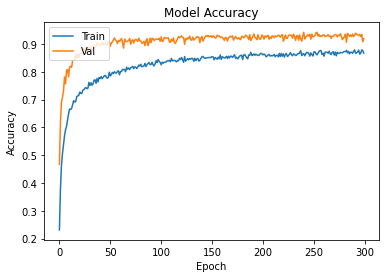

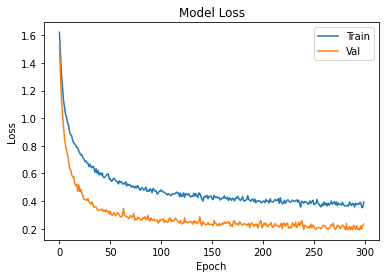

Train loss: 0.19826259
Train accuracy: 0.93153644
1446/1446 [==============================] - 0s 33us/sample - loss: 0.2125 - acc: 0.9246
Test loss: 0.21254716621889613
Test accuracy: 0.9246196


In [15]:
## MODELO_2
model_2= tf.keras.models.Sequential([
    #DNN 1                                 
    tf.keras.layers.Dense(32, activation='relu',input_shape=(36,)),
    tf.keras.layers.Dropout(0.5),
    #DNN 2
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #DNN 3
    tf.keras.layers.Dense(y.shape[1], activation='softmax', name ="LastLayer")
])

#Summary
model_2.summary()

#Compile
model_2.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

#Entreno
batch_size = 25
epochs=300

history2=model_2.fit(X_train, y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_split=0.2,
                   verbose=0)

#Grafico
plot_acc(history2)
plot_loss(history2)


#Resultados conjunto Entrenamiento
train_loss, train_acc =model_2.test_on_batch(X_train, y_train)
print('Train loss:', train_loss)
print('Train accuracy:', train_acc)

#Evaluo contra TEST
test_loss, test_acc = model_2.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               9472      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
LastLayer (Dense)            (None, 5)                

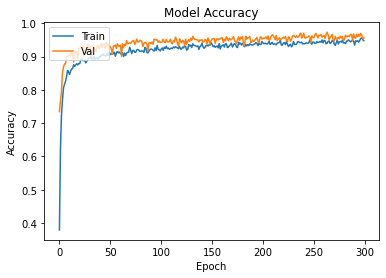

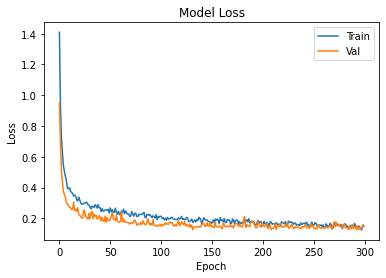

Train loss: 0.09233718
Train accuracy: 0.9695878
1446/1446 [==============================] - 0s 36us/sample - loss: 0.1877 - acc: 0.9557
Test loss: 0.1876502970277356
Test accuracy: 0.95574


In [16]:
## MODELO_3
model_3= tf.keras.models.Sequential([
    #DNN 1                                 
    tf.keras.layers.Dense(256, activation='relu',input_shape=(36,)),
    tf.keras.layers.Dropout(0.5),
    #DNN 2
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #DNN 3
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #DNN 4
    tf.keras.layers.Dense(y.shape[1], activation='softmax', name ="LastLayer")
])

#Summary
model_3.summary()

#Compile
model_3.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

#Entreno
batch_size = 32
epochs=300

history3=model_3.fit(X_train, y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_split=0.2,
                   verbose=0)

#Grafico
plot_acc(history3)
plot_loss(history3)


#Resultados conjunto Entrenamiento
train_loss, train_acc =model_3.test_on_batch(X_train, y_train)
print('Train loss:', train_loss)
print('Train accuracy:', train_acc)

#Evaluo contra TEST
test_loss, test_acc = model_3.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

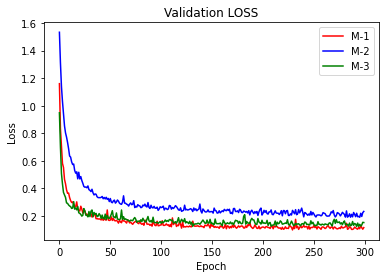

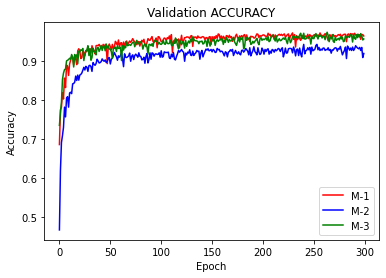

In [17]:
#Comparo ambas redes
#plot_compare_losses(history1, history3,"Modelo1","Modelo3", "Training and Validation LOSS")
#plot_compare_accs(history1, history3,"Modelo1","Modelo3", "Training and Validation ACCURACY")
#Comparo ambas redes
plot_compare_losses(history1, history2, history3, "M-1","M-2","M-3", "Validation LOSS")
plot_compare_accs(history1, history2, history3, "M-1","M-2","M-3", "Validation ACCURACY")

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       335
           1       0.87      0.98      0.92       276
           2       0.97      0.98      0.97       270
           3       0.99      0.97      0.98       294
           4       0.99      0.96      0.97       271

    accuracy                           0.96      1446
   macro avg       0.96      0.96      0.96      1446
weighted avg       0.96      0.96      0.96      1446



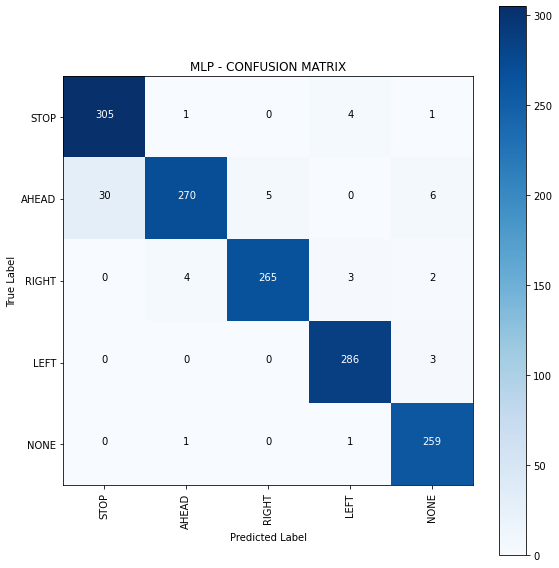

In [18]:
#Genero Matriz de Confusión. Ejemplo tomado SKLeran

# MODEL 1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

MAP_POSES = { 0: 'STOP', 1: 'AHEAD', 2: 'RIGHT',3: 'LEFT', 4: 'NONE'}

# Predict the values from the validation dataset
Y_pred = model_1.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = list(MAP_POSES.values()))

print(classification_report(Y_pred_classes, Y_true))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       317
           1       0.88      0.86      0.87       317
           2       0.95      0.98      0.97       264
           3       0.94      0.98      0.96       276
           4       0.98      0.94      0.96       272

    accuracy                           0.92      1446
   macro avg       0.93      0.93      0.93      1446
weighted avg       0.92      0.92      0.92      1446



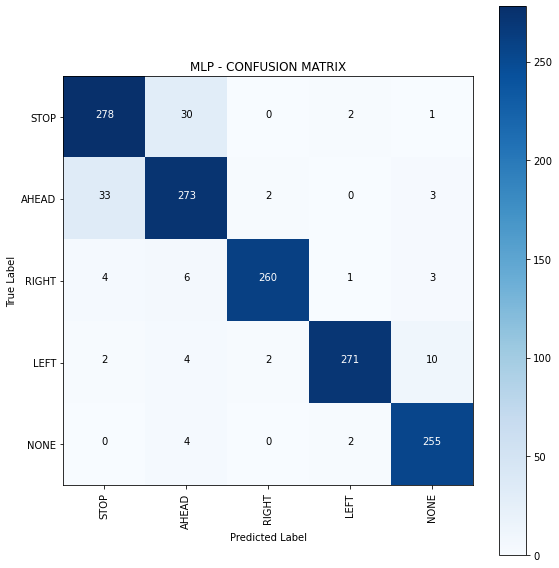

In [19]:
#Genero Matriz de Confusión. Ejemplo tomado SKLeran
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

MAP_POSES = { 0: 'STOP', 1: 'AHEAD', 2: 'RIGHT',3: 'LEFT', 4: 'NONE'}

# Predict the values from the validation dataset
Y_pred = model_2.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = list(MAP_POSES.values()))

print(classification_report(Y_pred_classes, Y_true))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       329
           1       0.90      0.96      0.93       292
           2       0.96      0.98      0.97       266
           3       0.98      0.97      0.97       291
           4       0.99      0.97      0.98       268

    accuracy                           0.96      1446
   macro avg       0.96      0.96      0.96      1446
weighted avg       0.96      0.96      0.96      1446



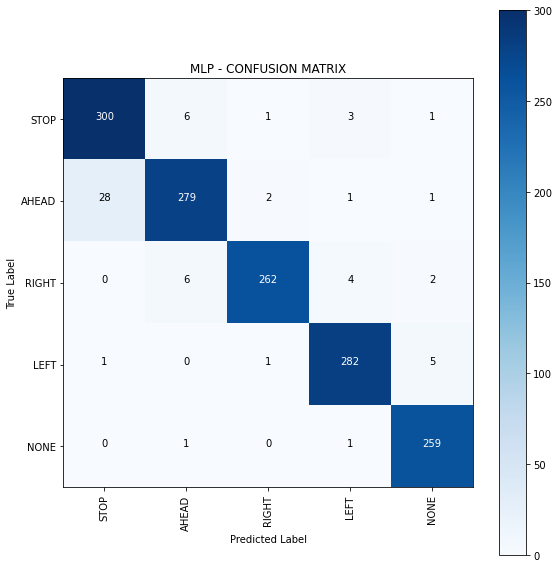

In [28]:
#Genero Matriz de Confusión. Ejemplo tomado SKLeran
from sklearn.metrics import confusion_matrix
import itertools

MAP_POSES = { 0: 'STOP', 1: 'AHEAD', 2: 'RIGHT',3: 'LEFT', 4: 'NONE'}

# Predict the values from the validation dataset
Y_pred = model_3.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = list(MAP_POSES.values()))

print(classification_report(Y_pred_classes, Y_true))

### Save MODEL:

In [29]:
model_1.save(PATH+'model_fusion_MLP.h5')

### UPLOAD MODEL:

In [22]:
#model_0=tf.keras.models.load_model('data/Final/model_n1n2n3_v10/model_n1n2n3_v10.h5')

In [23]:
model_0.test_on_batch(X_train, y_train)

[0.76743025, 0.84466356]